In [1]:
import matplotlib.pylab as plt
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.neural_network import MLPRegressor
from sklearn.neural_network import MLPClassifier
import copy
from distribuciones import espirales_anidadas
from random import sample
import warnings
warnings.filterwarnings("ignore")

4. Regularización: Vamos a usar regularización por penalización, el weight-decay. Hay que tener cuidado con los nombres de los parámetros en este caso. El parámetro que nosotros llamamos gamma en la teoría corresponde en MLP de sklearn al parámetro alpha, mientras que nosotros usamos alfa para el momentum en general. Para activarlo tenemos que usar:

-------------
gamma=0.00001
regr = MLPRegressor(hidden_layer_sizes=(N2,), activation='logistic', solver='sgd', alpha=gamma, batch_size=1, learning_rate='constant', learning_rate_init=eta,momentum=alfa,nesterovs_momentum=False,tol=0.0,warm_start=True,max_iter=epocas_por_entrenamiento)
--------------
En este tipo de regularización no se usa un conjunto de validación, asi que hay que modificar la función que crearon para evaluar el entrenamiento de las redes, para que en lugar del error sobre el conjunto de validación, nos devuelva la suma de los valores absolutos o de los valores al cuadrado de todos los pesos de la red en la epoca correspondiente, y todo el resto igual que antes.

Una vez implementado, aplíquelo al dataset Sunspots (ssp). Busque el valor de gamma adecuado para conseguir un equilibrio entre evitar el sobreajuste y hacer el modelo demasiado rígido (el valor de gamma se debe variar en varios órdenes de magnitud, por ejemplo empezar en 10^-6 e ir hasta 10^0 (1) de a un orden cada vez). En este caso todos los registros del archivo .data se deben usar para el entrenamiento, ya que la regularización se realiza con la penalización a los pesos grandes. 
Los otros parámetros se pueden tomar: learning rate 0.05, momentum 0.3, 4000 evaluaciones del entrenamiento, cada una de 20 épocas, 6 neuronas en la capa intermedia.

Entregue curvas de los tres errores (entrenamiento y test en una figura, penalización en otra figura) para el valor de gamma elegido, y para algún otro valor en que haya observado sobreajuste. Comente los resultados.

In [2]:
# Regularizacion implica que ahora la funcion que estoy minimizando no solo tiene que ver
# con los costos sino que tambien tiene un termino que penaliza la complejidad de la red.
# penaliza que los pesos sean muy grandes.. entonces evita sobreajuste ?

In [3]:
data = pd.read_csv('ssp.data',header=None)
test = pd.read_csv('ssp.test',header=None)

In [4]:
x_train = data.iloc[:,:12]
y_train = data.iloc[:,12]

x_test = test.iloc[:,:12]
y_test = test.iloc[:,12]

In [11]:
lrate = 0.05
pmom  = 0.3
ntest = 2000
evaluaciones = 4000
epocas = 20
neuronas = 6

In [12]:
gamma=0.00001
regr = MLPRegressor(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', 
                    alpha=gamma, batch_size=1, learning_rate='constant', 
                    learning_rate_init=lrate,momentum=pmom,nesterovs_momentum=False,
                    tol=0.0,warm_start=True,max_iter=epocas)

In [13]:
regr.fit(x_train,y_train)

MLPRegressor(activation='logistic', alpha=1e-05, batch_size=1,
             hidden_layer_sizes=(6,), learning_rate_init=0.05, max_iter=20,
             momentum=0.3, nesterovs_momentum=False, solver='sgd', tol=0.0,
             warm_start=True)

In [14]:
from sklearn.metrics import mean_squared_error

def entrenar_red(evaluaciones,red,x_train,y_train,x_test,y_test):
    errores = []
    min_error = 9999999
    
    for i in range(evaluaciones):
        red.fit(x_train,y_train)
        #y_pred = red.predict(x_val)
        #error_val = sk.metrics.zero_one_loss(y_pred, y_val)
        #error_val = np.sqrt(mean_squared_error(y_pred, y_val))
        suma_pesos = np.sum(abs(regr.coefs_[0]))
        #errores.append(error_valid)
        if suma_pesos < min_error:
            min_error = suma_pesos
            mejor_red = copy.deepcopy(red)
            
    pred_test = mejor_red.predict(x_test)
    #error_test = sk.metrics.zero_one_loss(pred_test,y_test)
    error_test = (mean_squared_error(pred_test,y_test))
    pred_train = mejor_red.predict(x_train)
    #error_train = sk.metrics.zero_one_loss(pred_train,y_train)
    error_train = (mean_squared_error(pred_train,y_train))
    
    return red, error_train, error_test, min_error

In [15]:
%%time 

gammas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1]

etrain = []
etests = []
spesos = []

for gamma in gammas:
    print(gamma)
    regr = MLPRegressor(hidden_layer_sizes=(neuronas,), activation='logistic', solver='sgd', 
                    alpha=gamma, batch_size=1, learning_rate='constant', 
                    learning_rate_init=lrate,momentum=pmom,nesterovs_momentum=False,
                    tol=0.0,warm_start=True,max_iter=epocas)
    
    red, error_train, error_test, suma_pesos = entrenar_red(evaluaciones,regr,x_train,y_train,
                                                            x_test,y_test)
    
    etrain.append(error_train)
    etests.append(error_test)
    spesos.append(suma_pesos)

1e-06
1e-05
0.0001
0.001
0.01
0.1
CPU times: user 11min 6s, sys: 191 ms, total: 11min 6s
Wall time: 11min 6s


Text(0.5, 0, '$\\gamma$')

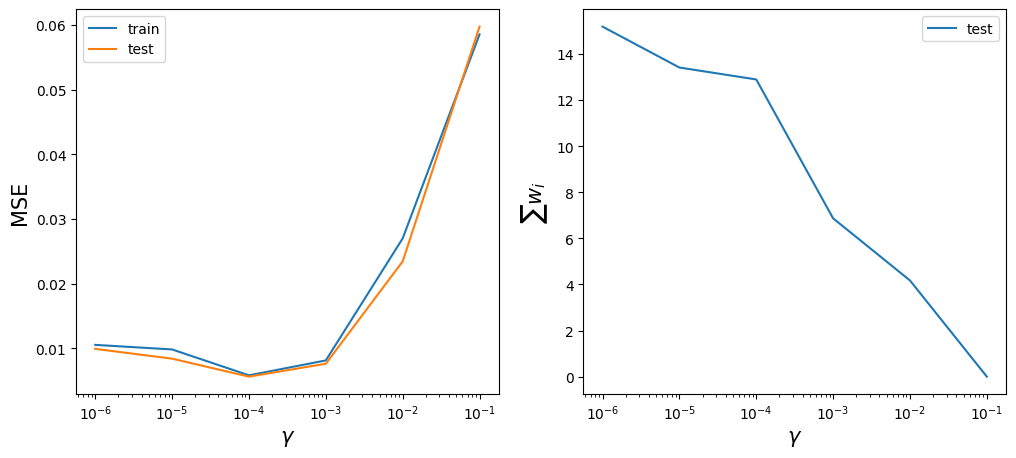

In [16]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.plot(gammas,etrain,label='train')
plt.plot(gammas,etests,label='test')
plt.legend()
plt.semilogx()
plt.ylabel('MSE',size=15)
plt.xlabel('$\\gamma$',size=15)

plt.subplot(122)
plt.plot(gammas,spesos,label='test')
plt.legend()
plt.semilogx()
plt.ylabel('$ \\sum w_i $',size=15)
plt.xlabel('$\\gamma$',size=15)

Si el valor de gamma es demasiado grande, los coeficientes de la red se reducirán en exceso y el modelo tendrá una capacidad de generalización limitada. Por otro lado, si el valor de gamma es demasiado pequeño, la red no se regularizará lo suficiente y el modelo seguirá sobreajustando.
e
el error de test puede dar chivo porue el conjunto de test aca es chiquito (entreno con 200 y testeo con 100)